In [1]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy       as np
import pretty_midi as pm
import librosa     as lbr
from   librosa.display import specshow
import tensorflow  as tf

In [2]:
interp = tf.lite.Interpreter(model_path="onsets_frames_wavinput.tflite")
interp.get_input_details(), interp.get_output_details()

([{'name': 'Placeholder',
   'index': 16,
   'shape': array([17920]),
   'shape_signature': array([17920]),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}}],
 [{'name': 'frame_logits',
   'index': 1332,
   'shape': array([ 1, 32, 88]),
   'shape_signature': array([ 1, 32, 88]),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 0},
   'sparsity_parameters': {}},
  {'name': 'onset_logits',
   'index': 2635,
   'shape': array([ 1, 32, 88]),
   'shape_signature': array([ 1, 32, 88]),
   'dtype': numpy.float32,
   'quantization': (0.0, 0),
   'quantization_parameters': {'scales': array([], dtype=float32),
    'zero_points': array([], dtype=int32),
    'quantized_dimension': 

In [3]:
interp.allocate_tensors()
inputLen = interp.get_input_details()[0]['shape'][0]
interp.set_tensor(interp.get_input_details()[0]['index'], np.array(np.random.random_sample(inputLen), dtype=np.float32))
interp.invoke()
for output in interp.get_output_details():
    first32Chords = interp.get_tensor(output['index'])
    print(output['name'], first32Chords[0].min(), first32Chords[0].max(), '\n', first32Chords, end='\n\n')

frame_logits -23.69737 6.138942 
 [[[-10.075554   -8.374783   -6.84772   ... -16.522121  -14.521896
   -11.675898 ]
  [ -7.588108   -6.482976   -8.975293  ... -17.467564  -15.592136
   -12.42377  ]
  [ -6.4807262  -6.1015177 -11.316768  ... -20.001945  -19.071222
   -14.897568 ]
  ...
  [ -7.1594357  -6.243394   -5.824191  ... -16.188425  -20.882141
   -18.404758 ]
  [ -7.621876   -5.7240925  -6.9756927 ... -15.3395    -20.947762
   -16.949936 ]
  [ -8.354395   -7.688925   -8.928634  ... -15.203535  -21.160841
   -16.934267 ]]]

onset_logits -26.280355 2.1618528 
 [[[ -9.927405   -7.369683   -9.975944  ... -14.781149  -20.59234
   -21.875896 ]
  [ -8.494212   -6.497216   -9.745885  ... -16.438147  -20.16504
   -21.469685 ]
  [ -5.74159    -5.374315   -7.007977  ... -15.074481  -19.662813
   -19.571705 ]
  ...
  [ -7.404469  -13.952096   -9.1285095 ... -17.606022  -16.07436
   -18.246044 ]
  [-10.06579   -16.22526   -12.722668  ... -19.301077  -15.797797
   -17.987482 ]
  [-11.48592   -

# 1. Load the Song.

In [4]:
rate, songName = 16_000, './Test songs/MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_12_Track12_wav.wav'

song = lbr.effects.trim(lbr.load(songName, rate)[0])[0]
songLen = int(lbr.get_duration(song, rate))
print('Song duration\t{} min : {} sec'.format(songLen // 60, songLen % 60))

Song duration	0 min : 43 sec


# 2. Predict Probabilities.

In [5]:
interp.set_tensor(interp.get_input_details()[0]['index'], song[:inputLen])
interp.invoke()
for output in interp.get_output_details():
    first32Chords = interp.get_tensor(output['index'])
    print(output['name'], first32Chords[0].min(), first32Chords[0].max(), '\n', first32Chords, end='\n\n')

frame_logits -27.153994 0.8419235 
 [[[-14.042323  -12.16228   -15.464712  ... -19.305365  -17.50471
   -15.492955 ]
  [-14.720356  -12.98374   -16.597113  ... -22.14126   -18.51053
   -17.276787 ]
  [-16.611492  -13.866851  -16.829737  ... -23.895563  -20.367254
   -18.967611 ]
  ...
  [-13.751821  -13.166228  -14.316219  ... -18.07019   -17.144405
   -15.896842 ]
  [-12.448567  -13.176397  -12.176679  ... -14.821554  -15.790749
   -14.629224 ]
  [ -7.995164  -12.186578   -8.2076435 ... -10.337193  -14.158825
   -12.389364 ]]]

onset_logits -23.404188 1.6334646 
 [[[-13.625739  -13.542617  -10.938008  ... -15.825341  -14.930651
   -15.726932 ]
  [-14.180186  -10.902331  -11.793695  ... -15.237801  -15.9614105
   -16.198803 ]
  [-15.372886  -12.241614  -13.743533  ... -16.694813  -16.858574
   -17.099842 ]
  ...
  [-12.024006  -12.641288  -16.27623   ... -22.412968  -21.697542
   -21.875744 ]
  [ -8.250113  -12.320369  -13.584641  ... -23.404188  -18.041811
   -22.526606 ]
  [ -3.26754

# 3 Keep Only Notes with Probabilities >= some threshold.
From https://arxiv.org/pdf/1710.11153.pdf:

Page 1 "Abstract":

`During inference, we restrict the predictions from the framewise detector by not allowing a new note to start unless the onset detector also agrees that an onset for that pitch is present in the frame.`

Page 2, Section 3 "Model Configuration":

`An activation from the frame detector is only allowed to start a note if the onset detector agrees that an onset is present in that frame.`

Page 3, Section 3.1 "Velocity Estimation":

`At inference time the output is ... then transformed to a midi velocity by the following mapping:`
$$v_{midi} = 80 * v_{predicted} + 10$$
`The final mapping is arbitrary, but we found this leads to pleasing audio renderings.`

C:\Users\Evgeniy\Anaconda3\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


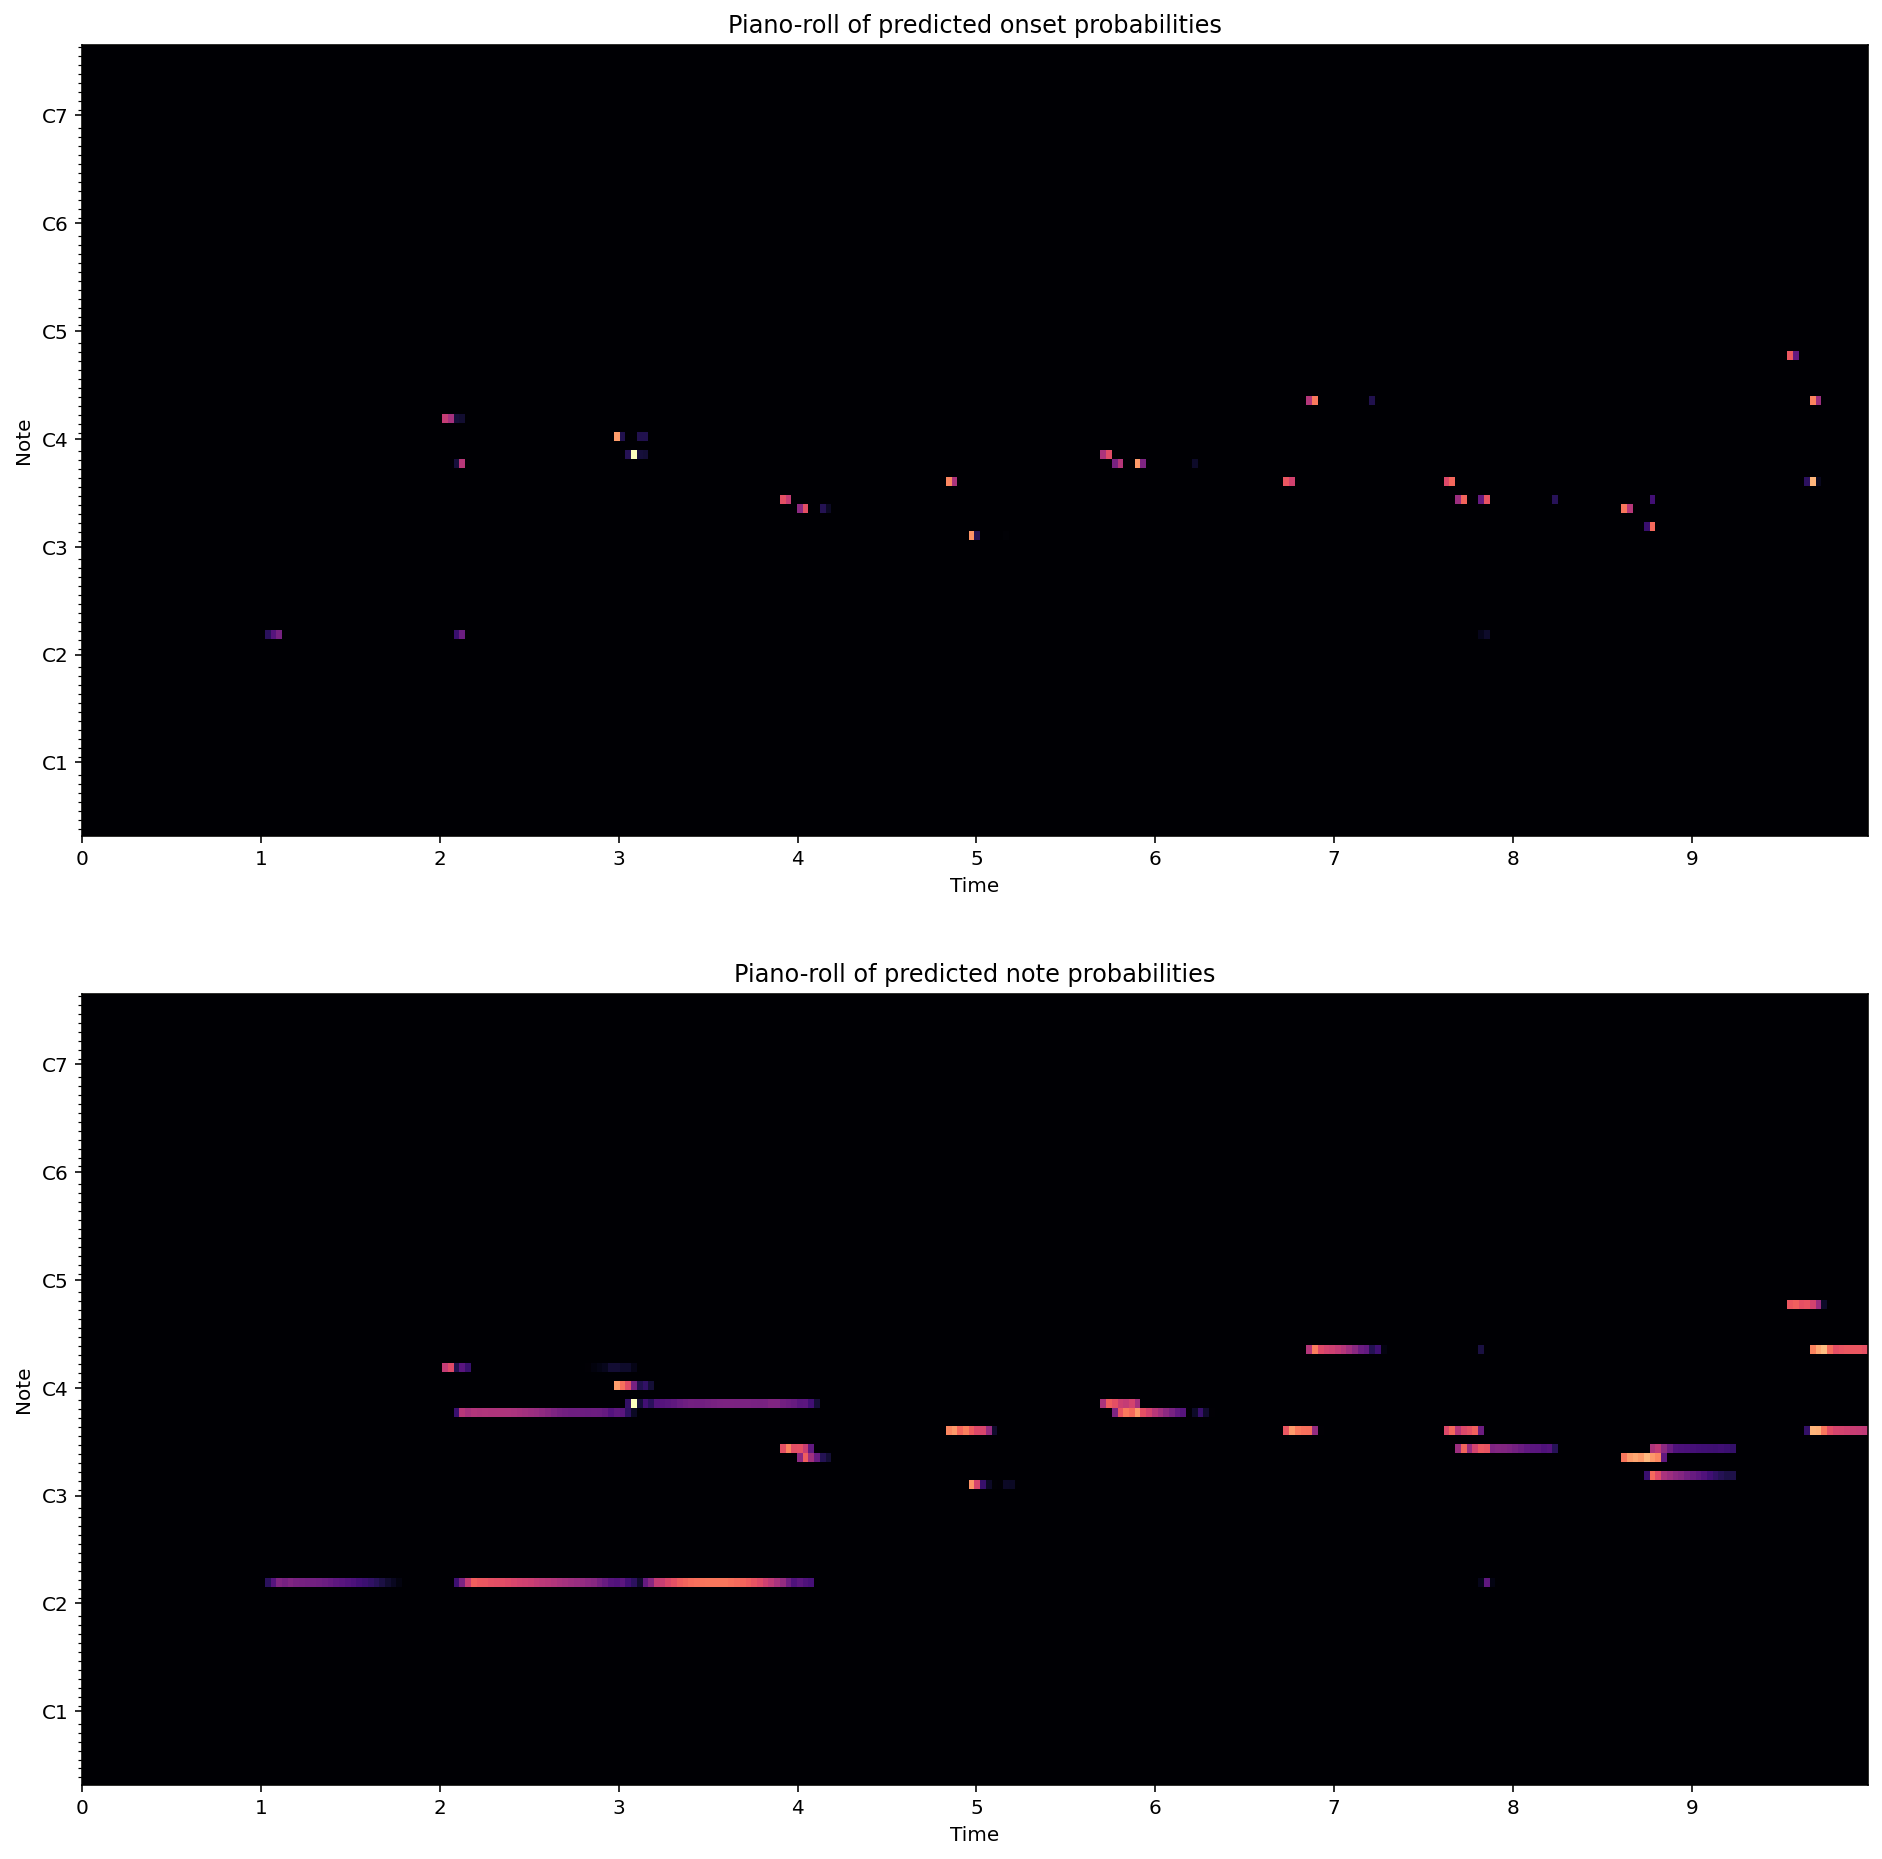

In [6]:
actProb, onProb, offProb, volProb = np.empty((1, 88)), np.empty((1, 88)), np.empty((1, 88)), np.empty((1, 88))
outputStep = interp.get_output_details()[0]['shape'][1] * 512
paddedSong = np.append(song, np.zeros(-(song.size - inputLen) % outputStep, dtype=np.float32))
for i in range((paddedSong.size - inputLen) // outputStep + 1):
    interp.set_tensor(interp.get_input_details()[0]['index'], paddedSong[i * outputStep : i * outputStep + inputLen])
    interp.invoke()
    actProb = np.vstack((actProb, interp.get_tensor(interp.get_output_details()[0]['index'])[0]))
    onProb  = np.vstack(( onProb, interp.get_tensor(interp.get_output_details()[1]['index'])[0]))
    offProb = np.vstack((offProb, interp.get_tensor(interp.get_output_details()[2]['index'])[0]))
    volProb = np.vstack((volProb, interp.get_tensor(interp.get_output_details()[3]['index'])[0]))

#############
threshold = 0
#############

plt.figure(figsize=(16, 16))
def PlotRoll(i, yProb, name):
    plt.subplot(2, 1, i)
    yProb[yProb < threshold] = 0
    specshow(yProb[0:lbr.time_to_frames(10, rate)].T, x_axis='time', y_axis='cqt_note', sr=rate, fmin=lbr.note_to_midi('A0'))
    plt.title('Piano-roll of predicted {} probabilities'.format(name))

PlotRoll(1, onProb, 'onset')
PlotRoll(2, np.maximum(onProb, actProb), 'note')

C:\Users\Evgeniy\Anaconda3\lib\site-packages\librosa\filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


(['Bb', 'Eb'], ['G', 'D', 'C', 'A', 'F', 'Eb', 'Bb'])

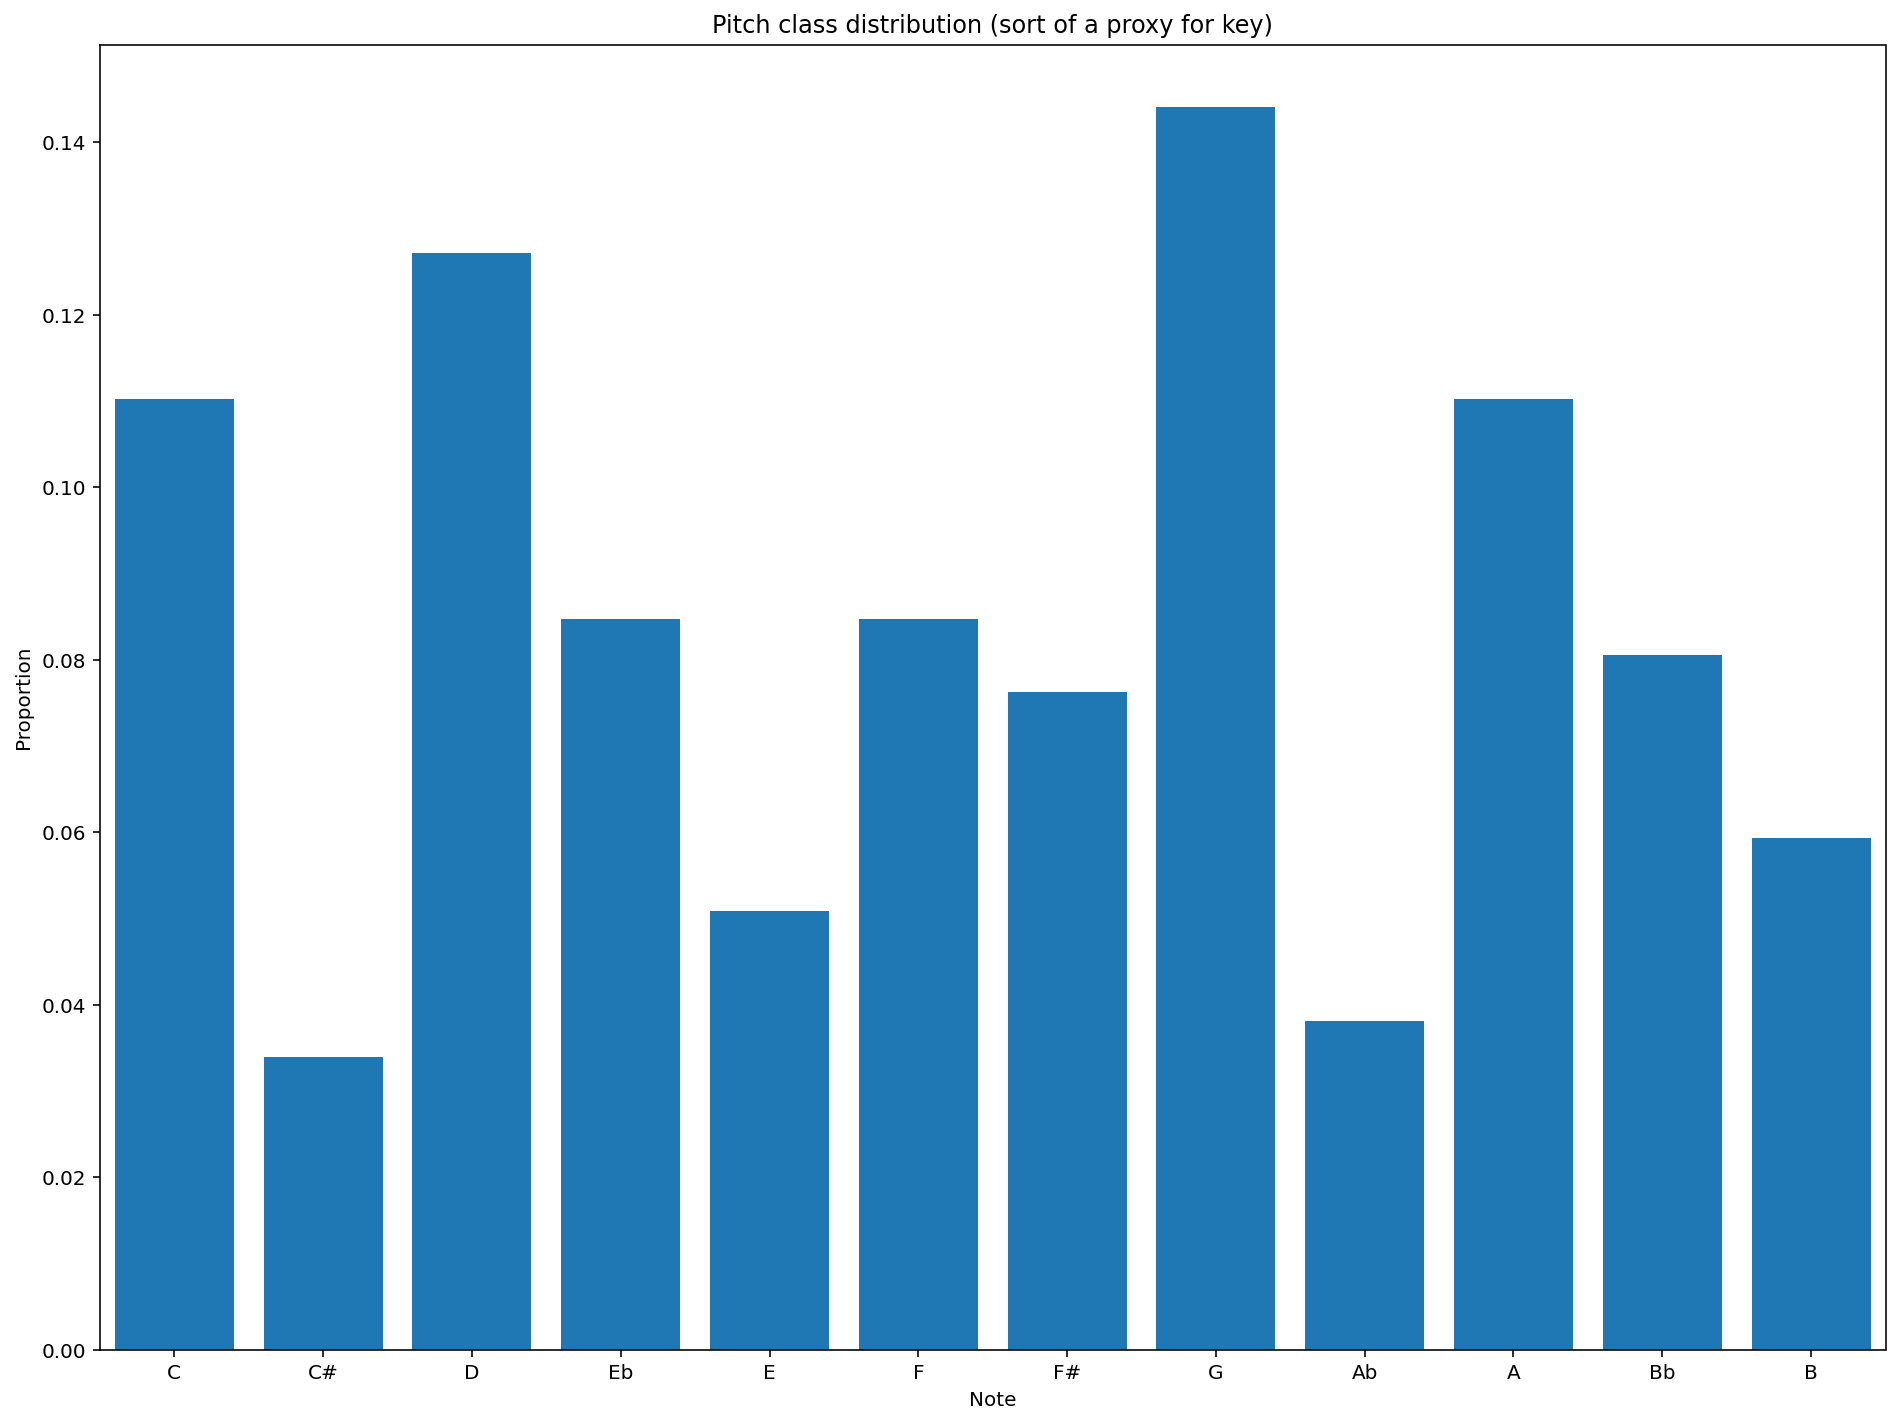

In [7]:
midi = pm.PrettyMIDI(initial_tempo=lbr.beat.tempo(song, rate).mean())
midi.lyrics += [pm.Lyric('Automatically transcribed from audio:\r\n\t' + songName, 0),
                pm.Lyric('Used software created by Boris Shakhovsky', 0)]
track = pm.Instrument(program=pm.instrument_name_to_program('Acoustic Grand Piano'), name='Acoustic Grand Piano')
midi.instruments += [track]

''' Based on https://github.com/tensorflow/magenta/blob/master/magenta/music/sequences_lib.py#L1844
    magenta.music.midi_ionote_sequence_to_midi_file(
    magenta.music.sequences_libpianoroll_to_note_sequence(fps=rate/512, min_duration=0, min_midi_pitch=21 ... '''

intervals, frameLenSecs = {}, lbr.frames_to_time(1, rate) # Time is in absolute seconds, not relative MIDI ticks
########################################################
onsets = (onProb > threshold).astype(np.int8)
frames = onsets | (actProb > threshold).astype(np.int8) # Ensure that any frame with an onset prediction is considered active.
#######################################################

def EndPitch(pitch, endFrame):
    #######################################################################################
    if volProb[intervals[pitch], pitch] < 0 or volProb[intervals[pitch], pitch] > 1: return
    #######################################################################################
    track.notes += [pm.Note(int(max(0, min(1, volProb[intervals[pitch], pitch])) * 80 + 10), pitch + 21,
                            intervals[pitch] * frameLenSecs, endFrame * frameLenSecs)]
    del intervals[pitch]

# Add silent frame at the end so we can do a final loop and terminate any notes that are still active:
for i, frame in enumerate(np.vstack([frames, np.zeros(frames.shape[1])])):
    for pitch, active in enumerate(frame):
        if active:
            if pitch not in intervals:
                if onsets is None: intervals[pitch] = i
                elif onsets[i, pitch]: intervals[pitch] = i # Start a note only if we have predicted an onset
                #else: Even though the frame is active, there is no onset, so ignore it
            elif onsets is not None:
                if (onsets[i, pitch] and not onsets[i - 1, pitch]):
                    EndPitch(pitch, i)   # Pitch is already active, but because of a new onset, we should end the note
                    intervals[pitch] = i # and start a new one
        elif pitch in intervals: EndPitch(pitch, i)

if track.notes: assert len(frames) * frameLenSecs >= track.notes[-1].end, 'Wrong MIDI sequence duration'

plt.figure(figsize=(16, 12))
#plt.subplot(2, 1, 1)

notes = midi.get_pitch_class_histogram()
plt.bar(np.arange(12), notes)
plt.xticks(np.arange(12), ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'])
plt.title('Pitch class distribution (sort of a proxy for key)')
plt.xlabel('Note')
plt.ylabel('Proportion')
plt.xlim(-.5, 11.5)

gamma = [n for _, n in sorted([(count, ['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'][i])
                               for i, count in enumerate(notes)], reverse=True)[:7]]
blacks = sorted(n for n in gamma if len(n) > 1)
blacks, gamma

# 4.1 Key Signature Estimation, Option 1.
### From Kumhansl and Schmuckler as reported here:
http://rnhart.net/articles/key-finding/

In [8]:
chroma = lbr.feature.chroma_cqt(song, rate).sum(1)
major = [np.corrcoef(chroma, np.roll([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88], i))[0, 1] for i in range(12)]
minor = [np.corrcoef(chroma, np.roll([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17], i))[0, 1] for i in range(12)]
keySignature = (['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'][
    major.index(max(major)) if max(major) > max(minor) else minor.index(max(minor)) - 3]
                + ('m' if max(major) < max(minor) else ''))
keySignature

'Em'

In [9]:
chroma = lbr.feature.chroma_cqt(C=onsets.T, fmin=lbr.note_to_hz('A0')).sum(1)
major = [np.corrcoef(chroma, np.roll([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88], i))[0, 1] for i in range(12)]
minor = [np.corrcoef(chroma, np.roll([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17], i))[0, 1] for i in range(12)]
keySignature = (['C', 'C#', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'Ab', 'A', 'Bb', 'B'][
    major.index(max(major)) if max(major) > max(minor) else minor.index(max(minor)) - 3]
                + ('m' if max(major) < max(minor) else ''))
keySignature

'Am'

# 4.2 Key Signature Estimation, Option 2.

In [10]:
MajorMinor = lambda mj, mn: mj if gamma.index(mj) < gamma.index(mn) else mn + 'm'

if len(blacks) == 0: keySignature = MajorMinor('C', 'A')

elif len(blacks) == 1:
    if blacks[0] == 'F#':
        assert 'F' not in gamma
        keySignature = MajorMinor('G', 'E')
    elif blacks[0] == 'Bb':
        assert 'B' not in gamma
        keySignature = MajorMinor('F', 'D')
    else: assert False

elif len(blacks) == 2:
    if blacks == ['C#', 'F#']:
        assert 'C' not in gamma and 'F' not in gamma
        keySignature = MajorMinor('D', 'B')
    elif blacks == ['Bb', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma
        keySignature = MajorMinor('Bb', 'G')
    else: assert False

elif len(blacks) == 3:
    if blacks == ['Ab', 'C#', 'F#']:
        assert 'C' not in gamma and 'F' not in gamma and 'G' not in gamma
        keySignature = MajorMinor('A', 'F#')
    elif blacks == ['Ab', 'Bb', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma and 'A' not in gamma
        keySignature = MajorMinor('Eb', 'C')
    else: assert False

elif len(blacks) == 4:
    if blacks == ['Ab', 'C#', 'Eb', 'F#']:
        assert 'C' not in gamma and 'D' not in gamma and 'F' not in gamma and 'G' not in gamma
        keySignature = MajorMinor('E', 'C#')
    elif blacks == ['Ab', 'Bb', 'C#', 'Eb']:
        assert 'B' not in gamma and 'E' not in gamma and 'A' not in gamma and 'D' not in gamma
        keySignature = MajorMinor('Ab', 'F')
    else: assert False

elif 'B' in gamma and 'E' in gamma: keySignature = MajorMinor('B', 'Ab')
elif 'C' in gamma and 'F' in gamma: keySignature = MajorMinor('C#', 'Bb')
else: assert False

keySignature

'Gm'

# 5. Finally, Write MIDI.
No instrument information is extracted, and all transcribed notes get combined into one part.

In [11]:
midi.key_signature_changes += [pm.KeySignature(pm.key_name_to_key_number(keySignature), 0)]
songName = '.'.join(songName.split('.')[:-1]) + '.mid'
midi.write(songName)
'{} saved'.format(songName)

'./Test songs/MIDI-Unprocessed_22_R1_2011_MID--AUDIO_R1-D8_12_Track12_wav.mid saved'